# Set up (+ reproducible results)

In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import math
%matplotlib inline

Using TensorFlow backend.


In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
# Setting the seed for numpy-generated random numbers
np.random.seed(54)

In [4]:
# Setting the seed for Python random numbers
rn.seed(28)

In [5]:
tf.set_random_seed(753)

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [7]:
train_path = 'towels/train/'
valid_path = 'towels/validate/'
test_path = 'towels/test/'

In [8]:
train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, 
                                   shear_range=0.15, zoom_range=0.1,
                                   channel_shift_range=10., horizontal_flip=False)

In [9]:
p, d, f = os.walk('towels/train/True').__next__()
train_sample_count = len(f)
p, d, f = os.walk('towels/train/False').__next__()
train_sample_count = train_sample_count + len(f)
train_batch_size = 32

p, d, f = os.walk('towels/validate/True').__next__()
valid_sample_count = len(f)
p, d, f = os.walk('towels/validate/False').__next__()
valid_sample_count = valid_sample_count + len(f)
valid_batch_size = 4

p, d, f = os.walk('towels/test/True').__next__()
test_sample_count = len(f)
p, d, f = os.walk('towels/test/False').__next__()
test_sample_count = test_sample_count + len(f)

In [10]:
#train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['True', 'False'], batch_size=10) 
train_batches = train_datagen.flow_from_directory(train_path, target_size=(224,224), classes=['True', 'False'], batch_size=train_batch_size) 
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['True', 'False'], batch_size=valid_batch_size) 
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['True', 'False'], batch_size=test_sample_count) 

Found 239 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [11]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [12]:
imgs, labels = next(train_batches)

/home/laus/.virtualenvs/virtual-py3/lib/python3.5/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


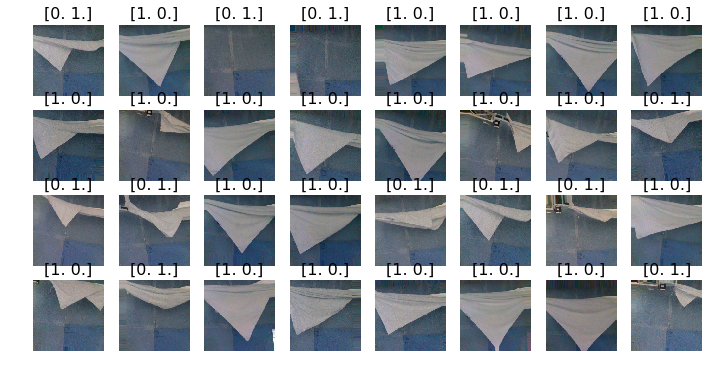

In [13]:
plots(imgs, titles=labels, rows = 4)

# Build and train CNN

# Predict

# Build Fine-tuned VGG16 model

In [14]:
vgg16_model = keras.applications.vgg16.VGG16()

vgg16_model.summary()

In [15]:
type(vgg16_model)

keras.engine.training.Model

In [16]:
model = Sequential()
for layer in vgg16_model.layers[:-4]:
    model.add(layer)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [18]:
for layer in model.layers:
    #layer.trainable = False
    layer.trainable = True

In [19]:
# First layer is a convolution with 20 functions and a kernel size of 5x5 (2 neighbor pixels on each side)
        model.add(Conv2D(20, (5, 5), padding="same",
            input_shape=(3,224,224)))
        # our activation function is ReLU (Rectifier Linear Units)
        model.add(Activation("relu"))
        # second layer is maxpooling 2x2 that reduces our image resolution by half 
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # Third Layer - Convolution, twice the size of the first convoltion
        model.add(Conv2D(40, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # Fifth Layer is Full connected flattened layer that makes our 3D images into 1D arrays
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(2))
        model.add(Activation("softmax"))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

# Train the fine-tuned VGG16 model

In [21]:
model.compile(Adam(lr=.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
steps_per_epoch  = math.ceil(train_sample_count/train_batch_size)
validation_steps = math.ceil(valid_sample_count/valid_batch_size)
print(steps_per_epoch)
print(validation_steps)

8
12


In [23]:
history = model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_batches, validation_steps=validation_steps, epochs=20, verbose=1, use_multiprocessing=True)

Epoch 1/20
8/8 [==============================] - 8s 944ms/step - loss: 0.5901 - acc: 0.6457 - val_loss: 0.3684 - val_acc: 0.7872
Epoch 2/20
8/8 [==============================] - 2s 264ms/step - loss: 0.3577 - acc: 0.8543 - val_loss: 0.2326 - val_acc: 0.9362
Epoch 3/20
8/8 [==============================] - 2s 263ms/step - loss: 0.2010 - acc: 0.9173 - val_loss: 0.4670 - val_acc: 0.9362
Epoch 4/20
8/8 [==============================] - 2s 254ms/step - loss: 0.2422 - acc: 0.9095 - val_loss: 0.1283 - val_acc: 0.9574
Epoch 5/20
8/8 [==============================] - 3s 416ms/step - loss: 0.1444 - acc: 0.9528 - val_loss: 0.1673 - val_acc: 0.9574
Epoch 6/20
8/8 [==============================] - 3s 414ms/step - loss: 0.1135 - acc: 0.9606 - val_loss: 0.1103 - val_acc: 0.9787
Epoch 7/20
8/8 [==============================] - 3s 409ms/step - loss: 0.1100 - acc: 0.9724 - val_loss: 0.6654 - val_acc: 0.8085
Epoch 8/20
8/8 [==============================] - 3s 409ms/step - loss: 0.2274 - acc: 0.92

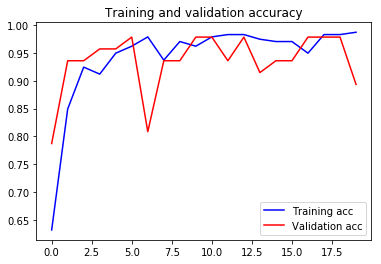

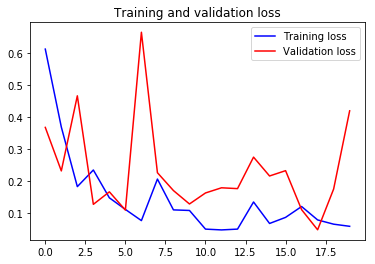

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Predict using fine-tuned VGG16 model

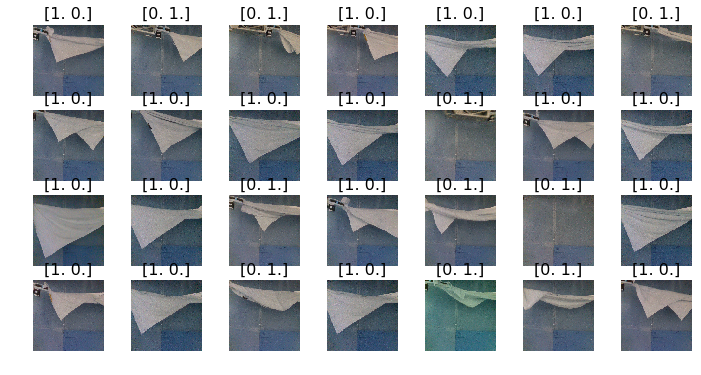

In [25]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels, rows=4)

<class 'numpy.ndarray'>


array([[[[ 58.,  75.,  76.],
         [ 41.,  82.,  65.],
         [ 56.,  72.,  70.],
         ...,
         [ 38.,  66.,  54.],
         [ 45.,  64.,  32.],
         [ 85.,  75.,  41.]],

        [[ 68.,  77.,  76.],
         [ 47.,  73.,  66.],
         [ 61.,  72.,  76.],
         ...,
         [ 36.,  58.,  51.],
         [ 55.,  66.,  45.],
         [ 78.,  77.,  60.]],

        [[ 65.,  78.,  76.],
         [ 62.,  75.,  74.],
         [ 66.,  71.,  74.],
         ...,
         [ 50.,  57.,  61.],
         [ 50.,  59.,  58.],
         [ 41.,  50.,  41.]],

        ...,

        [[ 89.,  97., 111.],
         [ 95.,  93.,  94.],
         [100.,  91., 107.],
         ...,
         [ 69.,  88., 102.],
         [ 73.,  89., 113.],
         [ 72., 100., 122.]],

        [[ 87.,  96., 105.],
         [ 93.,  97., 102.],
         [101.,  94., 115.],
         ...,
         [ 77.,  96., 110.],
         [ 75.,  91., 115.],
         [ 84.,  97., 116.]],

        [[100., 103., 119.],
       

In [27]:
test_labels = test_labels[:,0]
#test_labels

In [28]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
#np.round(predictions)

In [29]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

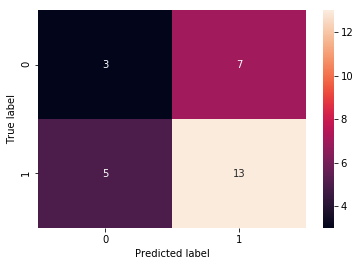

In [30]:
ax = plt.axes()
sns.heatmap(cm,annot=True,fmt='.5g', ax = ax) 
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



test_batches.class_indices

model.get_weights()